## Decision Tree Machine Learning Model

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

### Data Exploration and Preprocessing

In [30]:
df = pd.read_csv("n240.csv")

df = df.dropna(subset=['fire_occurrence'])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.describe()

,region_id,temperature,humidity,wind_speed,rainfall,drough_index,previous_fire,fire_occurrence
count,13977.000000,14018.000000,14002.000000,14001.000000,14005.000000,14006.000000,14013.000000,14293.000000
mean,25.504543,24.949192,50.026495,19.969888,6.018308,0.532367,0.397702,0.400826
std,14.426858,8.954107,22.230315,11.961369,10.015685,0.120682,0.489441,0.490083
min,1.000000,-2.934487,-0.979070,-7.498165,0.000000,0.003009,0.000000,0.000000
25%,13.000000,18.157908,30.130641,9.944791,0.000000,0.486219,0.000000,0.000000
50%,25.000000,25.001042,49.863411,19.886857,1.628201,0.559070,0.000000,0.000000
75%,38.000000,31.756289,69.925063,30.005607,7.793909,0.609216,1.000000,1.000000
max,50.000000,53.672885,101.474501,48.199633,114.091525,0.769467,1.000000,1.000000


In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14293 entries, 7956 to 16061
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   region_id        13977 non-null  float64
 1   date             14023 non-null  object 
 2   temperature      14018 non-null  float64
 3   humidity         14002 non-null  float64
 4   wind_speed       14001 non-null  float64
 5   rainfall         14005 non-null  float64
 6   vegetation_type  14021 non-null  object 
 7   drough_index     14006 non-null  float64
 8   previous_fire    14013 non-null  float64
 9   fire_occurrence  14293 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.2+ MB


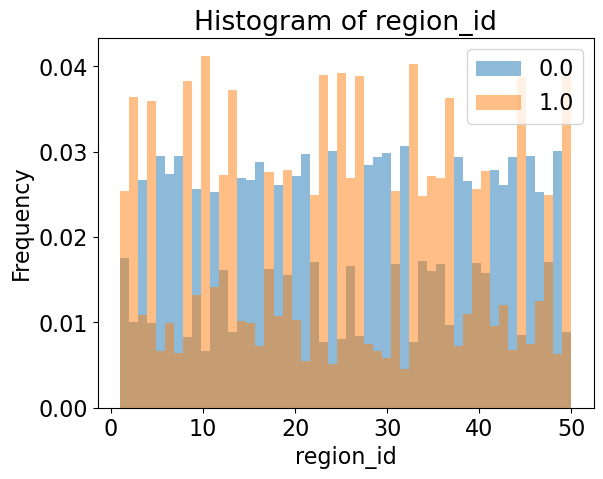

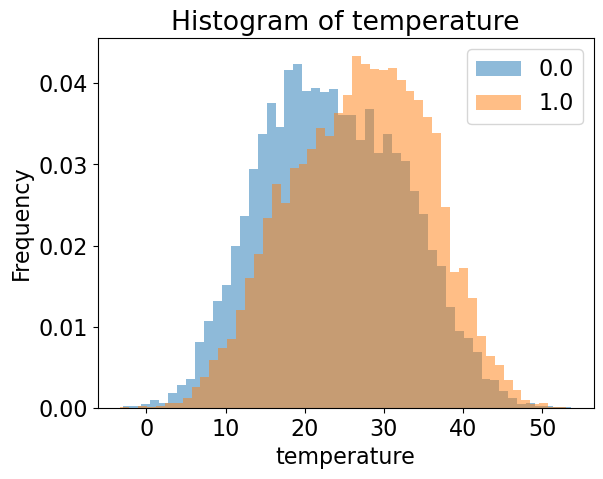

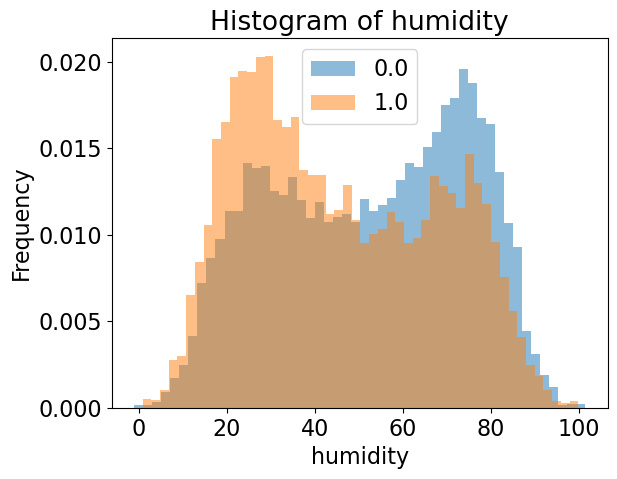

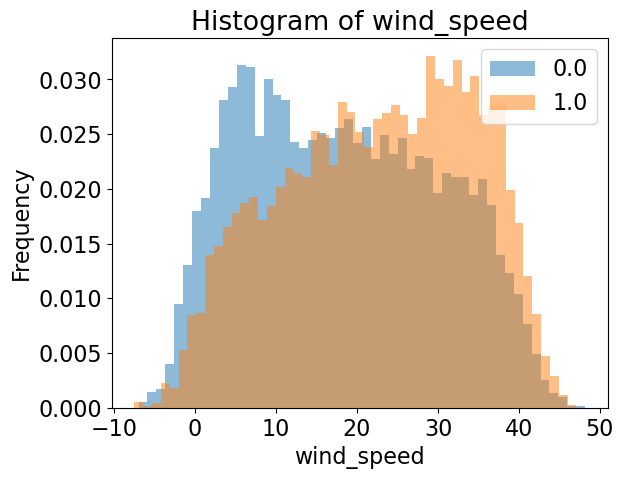

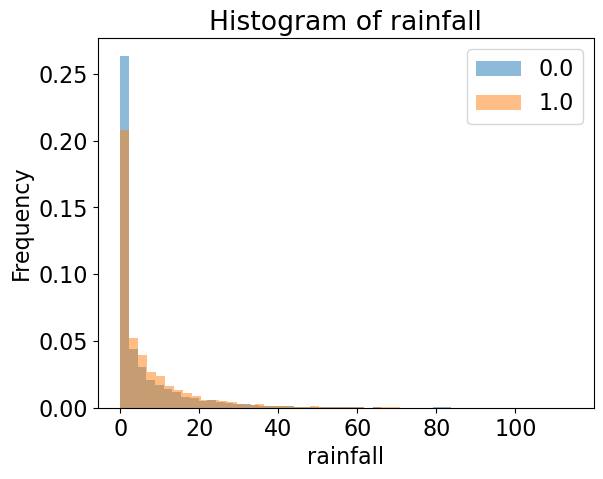

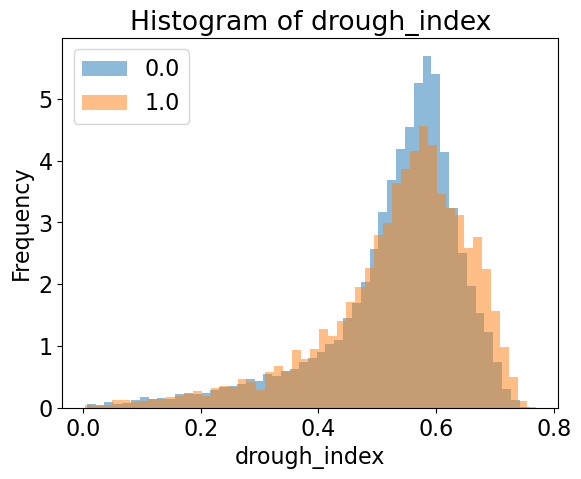

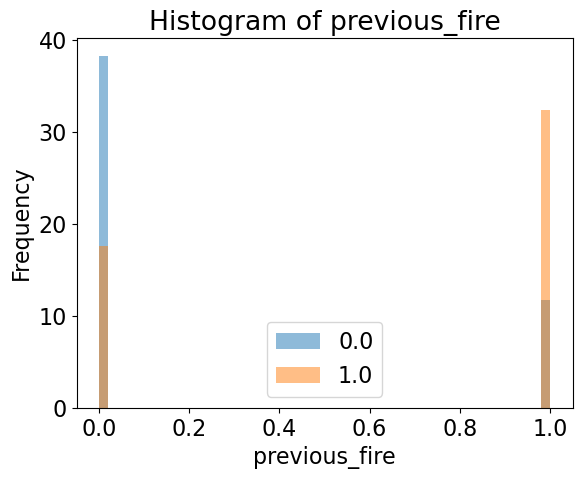

In [32]:
features = ['region_id', 'temperature', 'humidity', 'wind_speed','rainfall', 'drough_index', 'previous_fire']

for feat in features:
    df.groupby("fire_occurrence")[feat].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feat);
    plt.xlabel(feat)
    plt.show()

In [37]:
numerical_feature = ['temperature', 'humidity', 'wind_speed','rainfall', 'drough_index', 'previous_fire']
categorical_feature = ['vegetation_type']
drop_features = ['region_id', 'date', 'fire_occurrence']

In [38]:
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

preprocessor = make_column_transformer(
    (num_pipe, numerical_feature),
    (cat_pipe, categorical_feature)
)

### Model Development

In [39]:
X_train = train_df.drop(columns=drop_features)
y_train = train_df['fire_occurrence']
X_test = test_df.drop(columns=drop_features)
y_test = test_df['fire_occurrence']

In [44]:
pipe = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=123)
)
pipe.fit(X_train, y_train)
max_depth = pipe.named_steps['decisiontreeclassifier'].get_depth()
max_depth

36

In [45]:
depths = np.arange(1, max_depth, 2)
mean_train_accuracy = []
mean_validation_accuracy = []

for i in depths:
    pipe = make_pipeline(
        preprocessor,
        DecisionTreeClassifier(max_depth=i, random_state=123)
    )
    result = cross_validate(pipe, X_train, y_train, cv=10, return_train_score=True)
    mean_train_accuracy.append(result['train_score'].mean())
    mean_validation_accuracy.append(result['test_score'].mean())
    

results_df = pd.DataFrame({"train_score": mean_train_accuracy, 
                           "valid_score": mean_validation_accuracy
                           },
                           index=depths)


<Axes: title={'center': 'Pediction Tree Depths vs. Accuracy'}, xlabel='depths', ylabel='accuracy'>

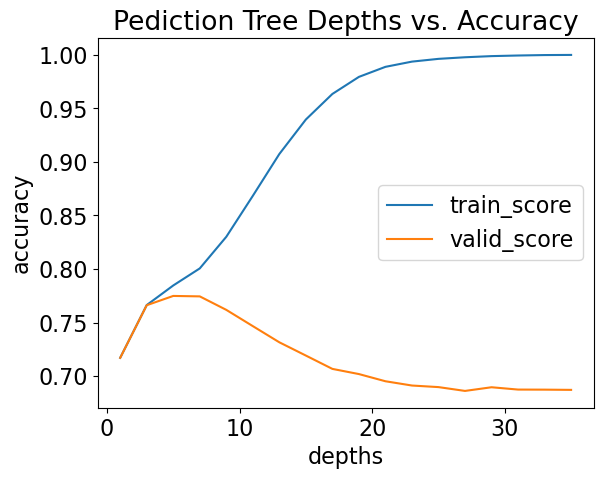

In [46]:
results_df.plot(ylabel="accuracy",xlabel="depths", title="Pediction Tree Depths vs. Accuracy")

In [49]:
best_max_depth = results_df['valid_score'].idxmax()
best_pipe = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(max_depth=best_max_depth, random_state=123)
)
best_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['temperature', 'humidity',
                                                   'wind_speed', 'rainfall',
                                                   'drough_index',
                                                   'previous_fire']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vegetation_type'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=np.int64(5),
                                        random_state=123))])

### Model Evaluation

In [51]:
test_score = best_pipe.score(X_test, y_test)
test_score

0.7728035814213766

In [57]:
importance = pd.DataFrame( 
    data = {
        "features": best_pipe.named_steps['decisiontreeclassifier'].n_features_in_,
        "feature_importances": best_pipe.named_steps['decisiontreeclassifier'].feature_importances_
    }
)
importance.sort_values("feature_importances", ascending=False)

,features,feature_importances
5,12,0.473237
8,12,0.195933
10,12,0.129018
2,12,0.094066
0,12,0.064734
1,12,0.030870
11,12,0.010660
3,12,0.001482
4,12,0.000000
6,12,0.000000
